In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 6:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'x_g' in i:
        list_dummies.append(i)
    elif 'a_g' in i:
        list_dummies.append(i)
    elif 'm_g' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [4]:
data_for_cluster = max_elemental.copy()
tree_for_cluster = DecisionTreeClassifier().fit(X=data_for_cluster.drop(['class'],axis=1),
                                                y=data_for_cluster['class'])
imp_feat_cluster = tree_for_cluster.feature_importances_
name_cluster = tree_for_cluster.feature_names_in_

imp_feat_cluster = imp_feat_cluster.reshape(-1,1)
name_cluster = name_cluster.reshape(-1,1)
df_for_cluster = pd.DataFrame(np.hstack((name_cluster,imp_feat_cluster)))
df_for_cluster.columns = ['names_feat','imp_feat']
df_for_cluster = df_for_cluster.set_index('names_feat',drop=True)
df_for_cluster = df_for_cluster[df_for_cluster['imp_feat'] > 0]
diff_z_cluster = list(df_for_cluster.index)



number_of_atoms_cluster = np.zeros(n_samples)
compteur_cluster = 0
for element in data_for_cluster.index:
    inter_cluster = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter_cluster.append(cara)
    if len(inter_cluster) == 1:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + 2
    elif len(inter_cluster) == 2:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + int(inter_cluster[1]) + 1
    elif len(inter_cluster) == 3:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + int(inter_cluster[1]) + int(inter_cluster[2])
    compteur_cluster += 1

columns_name_cluster = data_for_cluster.drop(['class'],axis=1).columns.copy()
normalized_cluster = data_for_cluster.drop(['class'],axis=1).to_numpy()/number_of_atoms_cluster.reshape(-1,1)

data_norm_cl = pd.DataFrame(normalized_cluster)
data_norm_cl.columns = columns_name_cluster
data_norm_cl['compound_name'] = data_for_cluster.index
data_norm_cl = data_norm_cl.set_index('compound_name',drop=True)

data_norm_cl = data_norm_cl.filter(items=list(diff_z_cluster),axis=1)
data_norm_cl['class'] = data_for_cluster['class'].copy()

retained_features_cl = list(df_for_cluster.index)

for feat in diff_z_cluster:
    if len(feat) > 6:
        retained_features_cl.remove(feat)

list_dummies_cl = []

for i in retained_features_cl:
    if 'M_' in i:
        list_dummies_cl.append(i)
    elif 'A_' in i:
        list_dummies_cl.append(i)
    elif 'X_' in i:
        list_dummies_cl.append(i)
    elif 'x_g' in i:
        list_dummies_cl.append(i)
    elif 'a_g' in i:
        list_dummies_cl.append(i)
    elif 'm_g' in i:
        list_dummies_cl.append(i)

for col in list_dummies_cl:
    for row in data_norm_cl.index:
        if data_norm_cl.loc[row,col] != 0:
            data_norm_cl.loc[row,col] = 1

In [5]:
data_norm_cl

,M_M_atomic_mass,M_M_density,M_M_average_ionic_radius,M_M_electronegativity,M_M_group,A_A_atomic_number,A_A_density,A_A_electron_affinity,A_A_second_ionization_energy,X_X_atomic_mass,X_X_atomic_radius,X_X_average_cationic_radius,X_X_valence_electrons,class
compound_name,,,,,,,,,,,,,,
Sc2AlC,11.238978,1.123898,0.221250,0.340,0.75,3.250,0.674538,0.108209,4.707137,3.002675,0.17500,0.075000,0.500,0.0
Sc2SiC,11.238978,1.123898,0.221250,0.340,0.75,3.500,0.702137,0.347380,4.086462,3.002675,0.17500,0.075000,0.500,0.0
Sc2PC,11.238978,1.123898,0.221250,0.340,0.75,3.750,0.774344,0.186652,4.942373,3.002675,0.17500,0.075000,0.500,0.0
Sc2SC,11.238978,1.123898,0.221250,0.340,0.75,4.000,0.801625,0.519276,5.834470,3.002675,0.17500,0.075000,0.500,0.0
Sc2MnC,11.238978,1.123898,0.221250,0.340,0.75,6.250,1.373451,-0.130000,3.909997,3.002675,0.17500,0.075000,0.500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W4AuN3,22.980000,2.298000,0.095833,0.295,0.75,9.875,2.462082,0.288576,2.525375,1.750838,0.08125,0.035625,0.375,0.0
W4HgN3,22.980000,2.298000,0.095833,0.295,0.75,10.000,2.507375,-0.065000,2.344610,1.750838,0.08125,0.035625,0.375,0.0
W4TlN3,22.980000,2.298000,0.095833,0.295,0.75,10.125,2.554791,0.040007,2.553538,1.750838,0.08125,0.035625,0.375,0.0


In [6]:
n_cluster=4
clusterized_data = KMeans(n_clusters=n_cluster).fit(data_norm_cl.to_numpy()[::-1])
data_norm_cl['cluster'] = clusterized_data.labels_
data_norm_cl = data_norm_cl.filter(items=['cluster'],axis=1)
data_norm = data_norm.merge(right=data_norm_cl, how='left',left_index=True,right_index=True)

In [7]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()/data_norm[data_norm['cluster'] == i].shape[0]
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_dist[i] = np.linalg.norm(clusterized_data.cluster_centers_[positive_cluster,:] - clusterized_data.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [8]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [9]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*10)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [10]:
reliable_negatives = reliable_negatives.head(n=n_positives*10)

In [11]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [12]:
gamma = 1
good_ratio = 1/10
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [13]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=50)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels*rbf(x=up_data_np,y=up_data_np[count_for_loop,:],l_squared=50))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [18]:
test_results = np.zeros(positive_samples.shape[0])
test_set = positive_samples.to_numpy()[:,:-3]

In [19]:
for i in range(positive_samples.shape[0]):
    test_results[i] = np.sign(np.sum(alpha*labels*rbf(x=up_data_np,y=test_set[i,:],l_squared=50))-b)

In [20]:
true_positives = 0
for i in range(positive_samples.shape[0]):
    if test_results[i] == 1:
        true_positives += 1

In [21]:
recall = true_positives/positive_samples.shape[0]

In [22]:
#'V4AlC3' 'Nb4AlC3' are missclassified
#'Ta4AlC3' is the 'frontier', it's the one that defines 'r'

In [23]:
number_of_predicted_positives = 0
for i in updated_data.drop(labels=list(positive_samples.index),axis=0).index:
    if updated_data.loc[i,'check_array'] == 1:
        number_of_predicted_positives += 1

In [24]:
weird_metric = (recall**2)/(number_of_predicted_positives/updated_data.drop(labels=list(positive_samples.index),axis=0).shape[0])

In [25]:
ordered_pred_df = updated_data[updated_data['check_array'] == 1].sort_values(by='to_det_b',ascending=False)

In [26]:
ordered_pred_df[ordered_pred_df['class'] == 1]

,A_A_second_ionization_energy,dMM,dMA,rMX,rMA,e_A,e_X,dEc,mass,density,...,M_Ti,M_V,A_Al,A_Zn,class,cluster,label,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,,
Ti3SnC2,2.438845,0.387375,0.394633,0.360033,0.497578,-0.123533,-0.304310,1121.749759,95.444333,0.982996,...,1.0,0.0,0.0,0.0,1.0,1,1.0,1.0,462.295815,1.0
Ti3ZnC2,2.994065,0.395818,0.380173,0.356583,0.481942,-0.123367,-0.302950,1046.059042,77.667667,0.843894,...,1.0,0.0,0.0,1.0,1.0,1,1.0,1.0,416.797746,1.0
Ti3SiC2,2.724308,0.399018,0.339795,0.357025,0.450538,-0.154085,-0.296233,1168.330449,65.236000,0.746292,...,1.0,0.0,0.0,0.0,1.0,3,1.0,1.0,407.243804,1.0
Ti3AlC2,3.138092,0.395053,0.382243,0.356595,0.483758,-0.113453,-0.300678,1128.862198,64.868180,0.702228,...,1.0,0.0,1.0,0.0,1.0,3,1.0,1.0,405.780410,1.0
V2AlC,4.707137,0.558340,0.541435,0.504640,0.685475,-0.063488,-0.411033,1507.684761,70.437769,1.212639,...,0.0,1.0,1.0,0.0,1.0,0,1.0,1.0,405.107968,1.0
Ta2AlC,4.707137,0.629637,0.557933,0.546693,0.714878,-0.015805,-0.456950,1884.426031,200.444149,2.870454,...,0.0,0.0,1.0,0.0,1.0,0,1.0,1.0,404.758651,1.0
Nb2AlC,4.707137,0.623830,0.559453,0.548930,0.719043,-0.055508,-0.426833,1702.981879,112.402639,1.578442,...,0.0,0.0,1.0,0.0,1.0,1,1.0,1.0,404.478226,1.0
Ti2SC,5.834470,0.559185,0.424882,0.540368,0.627973,-0.298357,-0.468533,1705.123542,69.902500,1.158582,...,1.0,0.0,0.0,0.0,1.0,0,1.0,1.0,404.207305,1.0
Ti2ZnC,4.491098,0.577213,0.571775,0.527335,0.722298,-0.187100,-0.483255,1396.775752,86.562500,1.289542,...,1.0,0.0,0.0,1.0,1.0,0,1.0,1.0,404.203552,1.0


In [27]:
ordered_pred_df = ordered_pred_df.head(100)

In [28]:
ordered_pred_df.to_csv('it_ls_svm_all_features.csv')

In [29]:
ordered_pred_df

,A_A_second_ionization_energy,dMM,dMA,rMX,rMA,e_A,e_X,dEc,mass,density,...,M_Ti,M_V,A_Al,A_Zn,class,cluster,label,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,,
Ti3SnC2,2.438845,0.387375,0.394633,0.360033,0.497578,-0.123533,-0.304310,1121.749759,95.444333,0.982996,...,1.0,0.0,0.0,0.0,1.0,1,1.0,1.0,462.295815,1.0
Ti3PdC2,3.238333,0.401270,0.358942,0.356510,0.464228,-0.157183,-0.298927,1134.605097,91.347667,1.025624,...,1.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,453.592079,1.0
Nb2SC,5.834470,0.559553,0.453543,0.554505,0.659473,-0.285247,-0.439273,1748.948380,114.941870,1.707358,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,449.958833,1.0
Ti2RhC,4.520000,0.607070,0.515502,0.530123,0.674270,-0.256800,-0.452525,1742.573366,105.325250,1.699645,...,1.0,0.0,0.0,0.0,0.0,0,-1.0,1.0,443.577849,1.0
Ta2NiN,4.542210,0.615050,0.497937,0.541540,0.668308,-0.207775,-0.443642,1810.273846,217.298080,3.389862,...,0.0,0.0,0.0,0.0,0.0,3,-1.0,1.0,422.234775,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ta2IrC,4.250000,0.630258,0.545785,0.544458,0.703570,-0.274625,-0.467625,2141.308250,283.061880,4.164196,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,404.207308,1.0
Ta2OsC,4.250000,0.639092,0.543998,0.545373,0.700897,-0.261325,-0.460848,2156.962766,282.068380,4.175184,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,404.207308,1.0
Zr2PN,4.942373,0.617660,0.447070,0.582675,0.666338,-0.372603,-0.463587,1713.660725,113.714381,1.538438,...,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,404.207308,1.0


In [30]:
df_to_plot = max_calculated.filter(items=list(ordered_pred_df.index),axis=0)
df_to_plot = df_to_plot.filter(items=['dEf','dH'],axis=1)

df_no_pos = max_calculated.drop(labels=list(ordered_pred_df.index),axis=0)
df_no_pos = df_no_pos.filter(items=['dEf','dH'],axis=1)

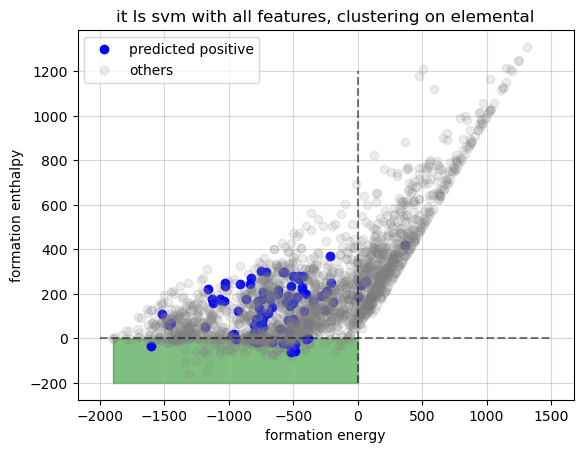

In [31]:
fig, ax = plt.subplots()

ax.plot(df_to_plot['dEf'].to_numpy(),df_to_plot['dH'].to_numpy(),'bo',
         label='predicted positive')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.15,
         label='others')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('it ls svm with all features, clustering on elemental')
plt.legend()
plt.savefig('it_ls_svm_pred_l_50_r_10_cl_elem.png')